### Notebook Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.width', 1000) #better print view
pd.set_option('display.max_colwidth', 200) 

random_seed = 88 #for replication

%load_ext autoreload
%autoreload 2

c:\Users\ekabu\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Load Dataset from File

The training data containing 3 columns:

* `Text`: Raw input text
* `Label`: Political tendency label (Democratic/Republican/NA)

In [2]:
df = pd.read_csv("subreddit_dataset_full_labeled_gpt4o.csv", sep=",")

df.head()

,Text,Label
0,"Forensic Audit: ""We conclude that the Dominion Voting System is intentionally and purposefully designed with inherent errors to create systemic fraud and influence election results."" So now that t...",Republican
1,"Biden and The Squad's Tlaib stage heated confrontation on tarmac in Detroit. Tlaib, your family is Hamas. Funded by Iran a state sponsor of terrorism. Hamas is a terrorist organization 3000 rocket...",Republican
2,"President-elect Biden is projected to win Pennsylvania and Nevada, putting him over 270 electoral votes. Most Republicans are happy with Biden as he will bring this country together and will have ...",NaN
3,Not even an issue of politics it's wrong this man is being charged. What is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ...,Republican
4,"Young man wearing MAGA hat attacked at school and spit on by two girls / animals. He deserves justice! We gotta start normalizing defending ourselves against women. Screw all that ""they're weaker""...",Republican


In [3]:
print("Number of samples: {}".format(len(df)))

#remove whitespaces from df
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
print(f"Unique labels: {df['Label'].unique()}")

Number of samples: 14048
Unique labels: ['Republican' nan 'Democratic' 'NA']


Let's exclude NA (Not Applicable) labels from the dataset

In [4]:
df = df.dropna()
df = df[df["Label"] != "NA"]

df.head()

,Text,Label
0,"Forensic Audit: ""We conclude that the Dominion Voting System is intentionally and purposefully designed with inherent errors to create systemic fraud and influence election results."" So now that t...",Republican
1,"Biden and The Squad's Tlaib stage heated confrontation on tarmac in Detroit. Tlaib, your family is Hamas. Funded by Iran a state sponsor of terrorism. Hamas is a terrorist organization 3000 rocket...",Republican
3,Not even an issue of politics it's wrong this man is being charged. What is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ...,Republican
4,"Young man wearing MAGA hat attacked at school and spit on by two girls / animals. He deserves justice! We gotta start normalizing defending ourselves against women. Screw all that ""they're weaker""...",Republican
6,"Trump says working on a very big trade deal with India, but will take time. India is, rightful, where we should pay a significant amount of our attention when it comes to that side of the world.",Republican


In [5]:
print("Number of samples: {}".format(len(df)))

Number of samples: 10979


Let's visualize the distribution of class labels in form of a pie chart.

<Axes: >

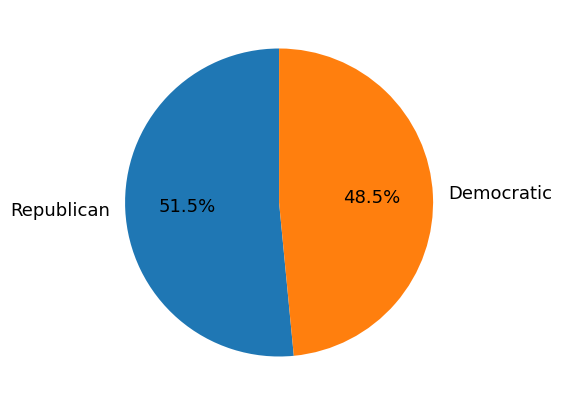

In [6]:
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

df['Label'].value_counts().plot.pie(**kwargs)

While not perfectly distributed, the class labels are arguebly well balanced.

#### Data Preparation

Text Preprocessing

In [7]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

LEMMATIZER = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))
#define custom stop words to ensure negation words are kept
WORDS_TO_KEEP = {'not', 'but', 'no', 'never', 'none', 'however', 'although', 'yet'}
CUSTOM_STOP_WORDS = STOP_WORDS.difference(WORDS_TO_KEEP)

#text preprocessing including case normalization, special character removal, lematization, etc.
def preprocess(text):
    # Lowercase and remove URLs/special characters
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s.?!.]', '', text)
    
    text = re.sub(r'(?<!\w)[.?!](?!\s|$)', '', text) #remove punctuation that is not at the end of a word
    
    # Remove repetitive characters e.g: looool -> lol. hahaha-> haha
    #text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'([a-z][a-z])\1+', r'\1\1', text)
    
    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    #Merge back tokens
    result = ""
    for i, token in enumerate(tokens):
        if i > 0 and re.match(r'[.?!,;:]', token):
            result += token  # No space before punctuation
        else:
            result += (" " if result else "") + token #space before word, no space at beginning.
    return result.strip()

df_clean = df.copy()
df_clean['Text'] =  df_clean['Text'].apply(preprocess)
df_clean['Text'] = df_clean['Text'].str.strip()
print(df_clean.head(5))
print(df_clean.shape)

                                                                                                                                                                                                      Text       Label
0  forensic audit we conclude that the dominion voting system is intentionally and purposefully designed with inherent error to create systemic fraud and influence election result. so now that they h...  Republican
1  biden and the squad tlaib stage heated confrontation on tarmac in detroit. tlaib your family is hamas. funded by iran a state sponsor of terrorism. hamas is a terrorist organization rocket shot at...  Republican
3  not even an issue of politics it wrong this man is being charged. what is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ab...  Republican
4  young man wearing maga hat attacked at school and spit on by two girl animal. he deserves justice! we got ta start normalizing defending 

Train-Val-Test split

In [24]:
#Encode labels
label_encoder = LabelEncoder()
df_clean['Label_encoded'] = label_encoder.fit_transform(df_clean['Label'])

print(df_clean.head(5))

# Split data
train_df, temp_df = train_test_split(df_clean, test_size=0.2, stratify=df_clean['Label_encoded'], random_state=random_seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label_encoded'], random_state=random_seed)

X_train = train_df['Text']
y_train = train_df['Label_encoded']

X_val = val_df['Text']
y_val = val_df['Label_encoded']

X_test = test_df['Text']
y_test = test_df['Label_encoded']

print(f"Size of X_train: {X_train.shape[0]}")
print(f"Size of X_val: {X_val.shape[0]}")
print(f"Size of X_test: {X_test.shape[0]}")

                                                                                                                                                                                                      Text       Label  Label_encoded
0  forensic audit we conclude that the dominion voting system is intentionally and purposefully designed with inherent error to create systemic fraud and influence election result. so now that they h...  Republican              1
1  biden and the squad tlaib stage heated confrontation on tarmac in detroit. tlaib your family is hamas. funded by iran a state sponsor of terrorism. hamas is a terrorist organization rocket shot at...  Republican              1
3  not even an issue of politics it wrong this man is being charged. what is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ab...  Republican              1
4  young man wearing maga hat attacked at school and spit on by two girl animal.

Tokenization and Embedding

In [9]:
from datasets import Dataset
from transformers import AutoTokenizer

# Select mode path here
pretrained_BertPolitical_path = "kornosk/bert-political-election2020-twitter-mlm"

# Load model
tokenizer = AutoTokenizer.from_pretrained(pretrained_BertPolitical_path)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256,  # Reddit posts can be long
        return_tensors="pt"
    )

# Convert Series to Hugging Face Datasets
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
val_dataset = Dataset.from_dict({"text": X_val.tolist(), "label": y_val.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

# Tokenize all datasets
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Parameter 'function'=<function tokenize at 0x000001F09283EE60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/8783 [00:00<?, ? examples/s]

Map:   0%|          | 0/1098 [00:00<?, ? examples/s]

Map:   0%|          | 0/1098 [00:00<?, ? examples/s]

In [10]:
%pip install --upgrade accelerate

Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Using CPU.")
# Choose GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU device: NVIDIA GeForce RTX 3050 Laptop GPU


Fine-Tuning the Model

In [12]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import torch

# Choose GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_BertPolitical_path,
    num_labels=2,  # Binary classification
    ignore_mismatched_sizes=True  # Required if the original model wasn't a classifier
)

# Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="binary")  # Use 'binary' for 2 classes
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,  # Start with 3 epochs (adjust based on early stopping)
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,  # Effective batch size = 16
    learning_rate=2e-5,
    fp16=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Optimize for F1 score
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kornosk/bert-political-election2020-twitter-mlm and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\ekabu\anaconda3\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\ekabu\anaconda3\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.477989,0.760474,0.766222
2,0.484700,0.461523,0.807832,0.820731
3,0.484700,0.496647,0.813297,0.825532
4,0.222000,0.604716,0.824226,0.831735


TrainOutput(global_step=1370, training_loss=0.29006853312471487, metrics={'train_runtime': 2343.5161, 'train_samples_per_second': 18.739, 'train_steps_per_second': 0.585, 'total_flos': 5758448557608960.0, 'train_loss': 0.29006853312471487, 'epoch': 4.983606557377049})

Evaluation on Test Set

In [14]:
test_results = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']:.2f}")
print(f"Test F1: {test_results['eval_f1']:.2f}")

Test Accuracy: 0.80
Test F1: 0.81


In [36]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)
pred_logits = predictions.predictions
true_labels = predictions.label_ids

# Convert logits to class predictions (0 or 1)
pred_classes = np.argmax(pred_logits, axis=1)

print(true_labels)
print(pred_classes)

[0 0 0 ... 0 0 0]
[1 0 1 ... 1 0 1]


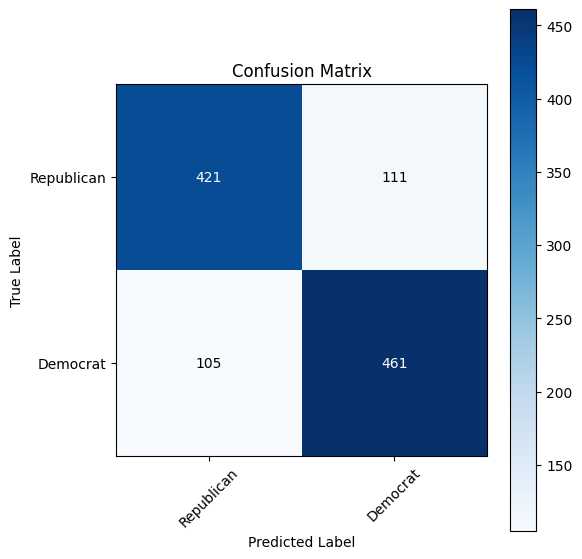

In [33]:
def plot_confusion_matrix(true_labels, pred_classes, classes):
    cm = confusion_matrix(true_labels, pred_classes)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Annotate cells with counts
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Define class names (adjust based on your LabelEncoder)
class_names = ["Republican", "Democrat"]  # Assuming 0=Republican, 1=Democrat
plot_confusion_matrix(true_labels, pred_classes, classes=class_names)
plt.show()

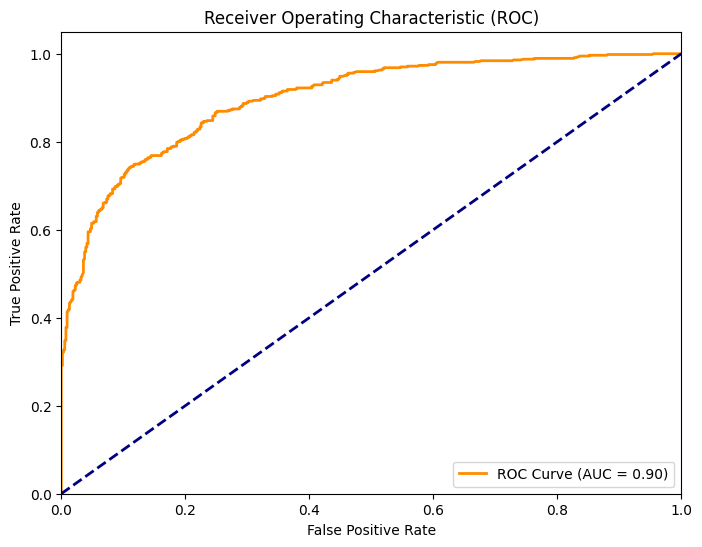

In [34]:
def plot_roc_curve(true_labels, pred_logits):
    # Get probabilities for the positive class (Democrat)
    pred_probs = pred_logits[:, 1]  # Use softmax if logits are not normalized
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(true_labels, pred_logits)

In [35]:
from sklearn.metrics import classification_report

print(classification_report(
    true_labels, 
    pred_classes, 
    target_names=class_names,
    digits=4
))

              precision    recall  f1-score   support

  Republican     0.8004    0.7914    0.7958       532
    Democrat     0.8059    0.8145    0.8102       566

    accuracy                         0.8033      1098
   macro avg     0.8032    0.8029    0.8030      1098
weighted avg     0.8032    0.8033    0.8032      1098



In [31]:
model.save_pretrained("./my_political_bert_model")  # Saves model weights + config
tokenizer.save_pretrained("./my_political_bert_model") 

('./my_political_bert_model\\tokenizer_config.json',
 './my_political_bert_model\\special_tokens_map.json',
 './my_political_bert_model\\vocab.txt',
 './my_political_bert_model\\added_tokens.json',
 './my_political_bert_model\\tokenizer.json')

Inference on New Text

In [30]:
def predict_political_leaning(texts):
    # Tokenize batch
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to("cuda")
    
    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert to probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
    
    # Create DataFrame
    results = pd.DataFrame({
        "text": texts,
        "prob_republican": probs[:, 1],
        "prob_democrat": probs[:, 0],
        "prediction": ["Republican" if x == 1 else "Democrat" for x in np.argmax(probs, axis=1)]
    })
    
    return results

# Example usage
texts = ["I support republicans",
         "I support democrats",
        "I strongly support republicans",
         "I strongly support democrat",
         "I love republicans",
         "I love democrats",
         "I hate republicans",
         "I hate democrats",
         "Trump is great",
         "Biden is good",
         "I support lower taxes and gun rights",
         "I support medicare and higher taxes for the rich"
]
print(predict_political_leaning(texts))

                                                text  prob_republican  prob_democrat  prediction
0                              I support republicans         0.354545       0.645455    Democrat
1                                I support democrats         0.069668       0.930332    Democrat
2                     I strongly support republicans         0.357399       0.642601    Democrat
3                        I strongly support democrat         0.279681       0.720319    Democrat
4                                 I love republicans         0.573275       0.426725  Republican
5                                   I love democrats         0.903294       0.096706  Republican
6                                 I hate republicans         0.442621       0.557379    Democrat
7                                   I hate democrats         0.974869       0.025131  Republican
8                                     Trump is great         0.907312       0.092688  Republican
9                             